# OPTIONAL: TMDB Box Office Prediction on Kaggle

 For this part of the homework 
You will need to look at the  [TMDB Box Office Prediction Competition on Kaggle](https://www.kaggle.com/c/tmdb-box-office-prediction)
Through the lectures and lab we learned how to predict house prices in California. In this homework, we adopted  the end to end pipeline to tackle the Titanic Survival problem. Now, we want you to adopt the machine learning pipeline to tackle the TMDB Box Office Prediction

In this dataset, you are provided with 7,398  movies (3,000 for training and 4,398 for testing) and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

Feel free to use the [Kaggle API](https://github.com/Kaggle/kaggle-api) for downloading the dataset or submitting to the competition. It is not mandatory to use the package but it would be interesting to explore.
   You will need to: 
* __Important:__ Make sure your results are reproducible 
* __Important:__ Use the training data set provided by the competition to create a training set(70%), validation set (15%) and a test set (15%)
* __EDA.__ Identify the types of data available, evaluate basic statistical information about the data and determine whether you have any missing or misformated data.

* __Feature Engineering.__  Develop at least one new feature based on the existing features of the dataset
* __Pre-processing.__  All work must be performed using pipelines.  You can adapt code from above or develop your own.
* __Modeling.__Evaluate at least two appropriate algorithms (estimators) for generating predictions.
    * Use grid search to tune hyperparameters.
    * Use crossfold evaluation (cv=5).
* __Evaluation.__ Select appropriate metrics for the problem to evaluate your models.
* __Reporting.__ Record all experiments in a table of results (pandas dataframe) including at least the following information:  
    * description of the model (algorithim, notable processing steps) 
    * key hyperparameters
    * results (using one or more appropriate metrics)
    * run time for each experiment (train and test results)
    * hardware used
* __Analysis__. Perform a significance test on your best models and discuss results (see Module 09.5 in Canvas for a video lecture on significance testing).
* __Submit your best model to Kaggle__ Provide a screenshot of the kaggle submission
* __Comment your code and provide explanations of how you're proceeding in each part__


## Data Import & notebook preperation


In [591]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


In [592]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [593]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [594]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

In [595]:
data = pd.read_csv('datasets/TMDB/train.csv')
#y = data ['revenue']
data = data .drop(['title', 'id', 'belongs_to_collection', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'cast', 'crew'], axis = 1)
test_data = pd.read_csv('datasets/TMDB/test.csv')


## EDA

In [404]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [596]:
data.dropna(subset=["genres", "Keywords", "production_countries", "production_companies","runtime", "spoken_languages" ], inplace=True)

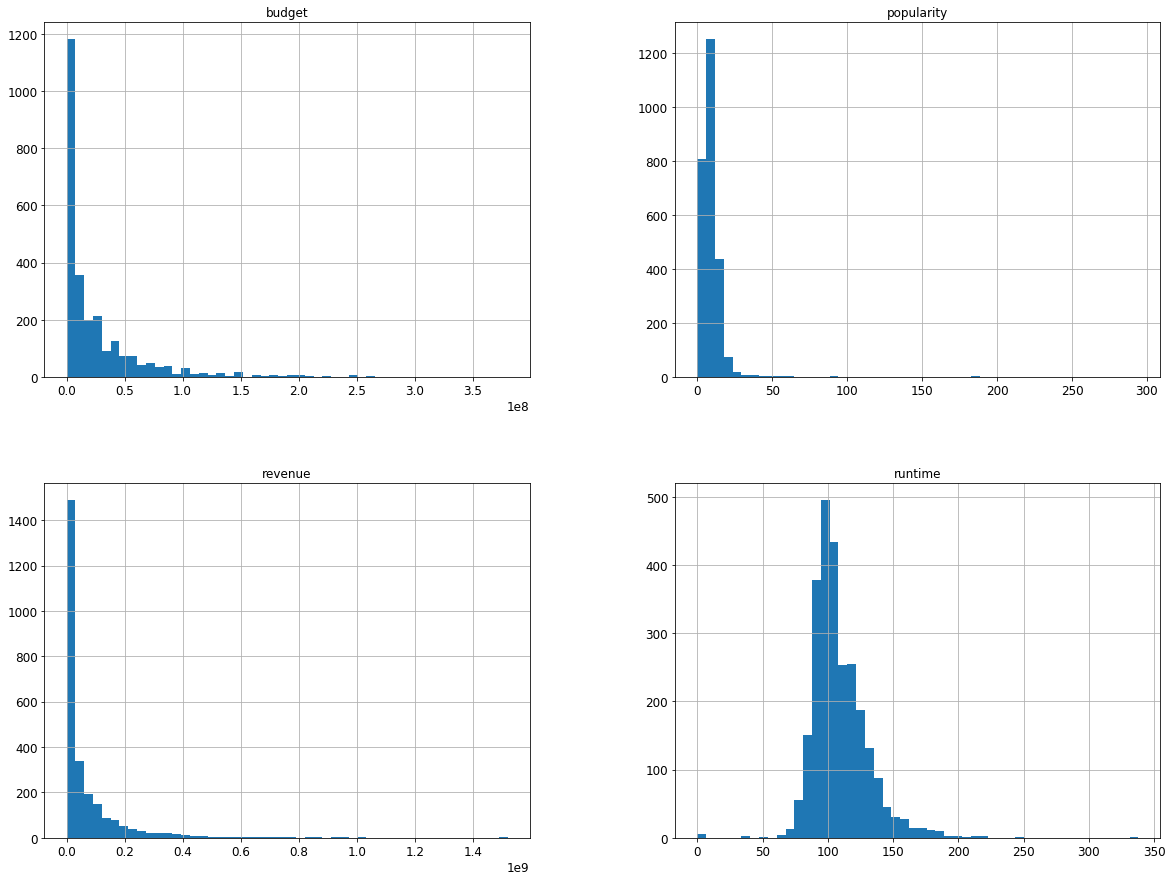

In [485]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [65]:
#data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

In [66]:
#import datetime
#dt = datetime.datetime.now().date()
#data['age'] = dt - pd.to_datetime(data['release_date']).dt.date 
#data['age'] = data.age.dt.days

In [517]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2622 entries, 0 to 2999
Data columns (total 12 columns):
budget                  2622 non-null int64
genres                  2622 non-null object
original_language       2622 non-null object
popularity              2622 non-null float64
production_companies    2622 non-null object
production_countries    2622 non-null object
release_date            2622 non-null object
runtime                 2622 non-null float64
spoken_languages        2622 non-null object
status                  2622 non-null object
Keywords                2622 non-null object
revenue                 2622 non-null int64
dtypes: float64(2), int64(2), object(8)
memory usage: 266.3+ KB


In [487]:
corr_matrix = data.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.747999
popularity    0.449099
runtime       0.218760
Name: revenue, dtype: float64

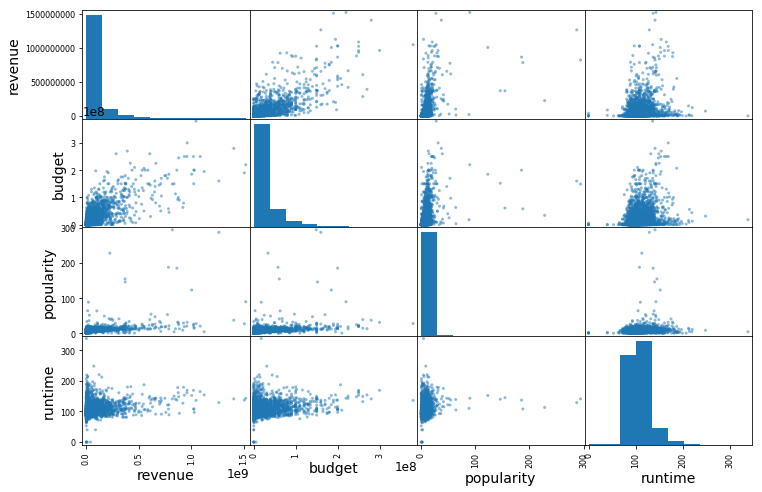

In [488]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with survived
attributes = ["revenue", "budget", "popularity", "runtime"]
scatter_matrix(data[attributes], figsize=(12, 8));

## Preprocessing


In [597]:
from ast import literal_eval
data.loc[:,'genres'] = data.loc[:,'genres'].apply(lambda x: literal_eval(x))
data.loc[:,'Keywords'] = data.loc[:,'Keywords'].apply(lambda x: literal_eval(x))
data.loc[:,'production_countries'] = data.loc[:,'production_countries'].apply(lambda x: literal_eval(x))
data.loc[:,'spoken_languages'] = data.loc[:,'spoken_languages'].apply(lambda x: literal_eval(x))
data.loc[:,'production_companies'] = data.loc[:,'production_companies'].apply(lambda x: literal_eval(x))

In [590]:
data['genre_new'] = data.apply(lambda row: row.genres[0]['name'], axis=1)
data['Keywords_new'] = data.apply(lambda row: row.Keywords[0]['name'], axis=1)
data['production_countries_new'] = data.apply(lambda row: row.production_countries[0]['name'], axis=1)
data['spoken_lang_new'] = data.apply(lambda row: row.spoken_languages[0]['name'], axis=1)
data['prod_company_new'] = data.apply(lambda row: row.production_companies[0]['name'], axis=1)

In [561]:
data.drop(['release_date','genres','production_companies','production_countries','spoken_languages', 'Keywords'], axis=1, inplace=True)

In [562]:
data.head()

,budget,original_language,popularity,runtime,status,revenue,genre_new,Keywords_new,production_countries_new,spoken_lang_new,prod_company_new
0,14000000,en,6.575393,93.0,Released,12314651,Comedy,time travel,United States of America,English,Paramount Pictures
1,40000000,en,8.248895,113.0,Released,95149435,Comedy,coronation,United States of America,English,Walt Disney Pictures
2,3300000,en,64.299990,105.0,Released,13092000,Drama,jazz,United States of America,English,Bold Films
8,0,en,6.902423,100.0,Released,34327391,Action,island,United States of America,English,Walt Disney Pictures
9,6000000,en,4.672036,91.0,Released,18750246,Comedy,mockumentary,United States of America,English,Castle Rock Entertainment


In [573]:
y = data['revenue']
#x = data['budget', 'popularity']
x = data[['budget', 'popularity', 'runtime']]
#x = data.drop('revenue', axis = 1)
#y = data['revenue'].values 
#x = data['popularity','budget','runtime']

# split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

In [574]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [578]:
linreg_scores = cross_val_score(lin_reg, x_train, y_train, scoring = "neg_mean_squared_error")

In [579]:
linreg_scores

array([-8.75273218e+15, -7.01259774e+15, -1.09899761e+16])

In [598]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        
        df = pd.DataFrame(X, columns=self.features)
        #df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        # Apply the necessary transformations to obtain the 5 title categories
        # (Mr, Mrs, Miss, Master, Other) like it was done in section 5.1.2
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        
        #import datetime
        #dt = datetime.datetime.now().date()
        #df['age'] = dt - pd.to_datetime(df['release_date']).dt.date 
        #data['age'].apply(lambda x:x.toordinal())
        #df['age'] = df.age.dt.days
        
        df.loc['genre_new'] = df.apply(lambda row: row.genres[0]['name'], axis=1)
        df.loc['Keywords_new'] = df.apply(lambda row: row.Keywords[0]['name'], axis=1)
        df.loc['production_countries_new'] = df.apply(lambda row: row.production_countries[0]['name'], axis=1)
        df.loc['spoken_lang_new'] = df.apply(lambda row: row.spoken_languages[0]['name'], axis=1)
        df['prod_company_new'] = df.apply(lambda row: row.production_companies[0]['name'], axis=1)
    
        df = df.drop(['id','release_date','genres','production_companies','production_countries','spoken_languages', 'Keywords', 'title'], axis=1, inplace=True)
        #return np.array(df.values)
        return df.values

#attr_adder = TitleAdder(features=None)

#imdb_extra_attribs = attr_adder.transform(data.values)

## Modeling

In [18]:
#from sklearn.model_selection import train_test_split

#train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

In [520]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2622 entries, 0 to 2999
Data columns (total 12 columns):
budget                  2622 non-null int64
genres                  2622 non-null object
original_language       2622 non-null object
popularity              2622 non-null float64
production_companies    2622 non-null object
production_countries    2622 non-null object
release_date            2622 non-null object
runtime                 2622 non-null float64
spoken_languages        2622 non-null object
status                  2622 non-null object
Keywords                2622 non-null object
revenue                 2622 non-null int64
dtypes: float64(2), int64(2), object(8)
memory usage: 266.3+ KB


In [599]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer

# Identify the numeric features we wish to consider. 
num_attribs = [
    'budget', 
    'popularity',
    'runtime',
   # 'age'
   # 'revenue'
]
# Create a pipeline for the numeric features.
# Use DataFrameSelector with the numeric features defined above
# Use StandardScaler() to standardize the data
# Missing values will be imputed using the feature median.
#==================================================#
#               Your code starts here              #
#==================================================#      
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', TitleAdder()),
        ('std_scaler', StandardScaler()),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#


# Identify the categorical features we wish to consider.
cat_attribs = [
    "genres", 
    "Keywords",
    "production_countries",
    "original_language",
    "spoken_languages"
   # "status"
  #  "release_date"
]
# Identiy the range of expected values for the categorical features.
#cat_values = [
    #['S','C','Q'],     # Embarked
    #['female','male'], # Sex
    #[1,2,3] # Pclass
#]
# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('attribs_adder', FeatureAdder()),
        ('ohe', OneHotEncoder(handle_unknown="ignore"))
    ])

# Union the transformed, scaled numeric and categorical features.
#==================================================#
#               Your code starts here              #
#==================================================#

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#



## Evaluation, reporting and analysis


In [207]:
#y = data['revenue']
#x = data.drop(['revenue'], axis = 1)

In [600]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("Linear Regression", LinearRegression())
    ])

#some_data = data.iloc[:500]
#some_labels = housing_labels.iloc[:5]
#some_data_prepared = full_pipeline.transform(some_data)


y = data['revenue']
#x = data.drop('revenue', axis = 1)
#y = data['revenue'].values 
x = data.drop(['revenue'], axis = 1)

# split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

In [558]:
y_train.head()

2021      260354
1736    23507567
192     37915971
1119    35287788
58        119563
Name: revenue, dtype: int64

In [601]:
#full_pipeline_with_predictor.fit(x_train, y_train)
full_pipeline_with_predictor.fit(pd.DataFrame(x_train, y_train))

TypeError: unhashable type: 'list'

In [602]:
start = time()
full_pipeline_with_predictor.fit(x_train, y_train)
np.random.seed(42)
from sklearn.metrics import mean_squared_error, r2_score

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv10Splits = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
#logit_scores = cross_val_score()        
linreg_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train,
                         scoring = "neg_mean_squared_error" , cv=cv30Splits)
#linreg_scores = np.sqrt(-linreg_scores)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
linreg_score_train = linreg_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
linreg_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

TypeError: unhashable type: 'list'

In [392]:
results.loc[0] = ["Baseline_IMDB", pct(linreg_score_train), np.round(pct(linreg_score_test),3), 
                  "---", train_time, test_time, "Untuned LinearRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline_IMDB,-2.049943e+18,5.7,---,4.414,0.006,Untuned LinearRegression


In [397]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression()),
    #    ('Linear Regression', LinearRegression())
      #  ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        #('Support Vector', SVC(random_state=42))
        #('Stochastic GD', SGDClassifier(random_state=42))
        ('RandomForest', RandomForestClassifier())
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
   #     'Linear Regression' : {},
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
           # 'tol': (0.0001, 0.00001, 0.0000001),
            'tol': (0.0001, 0.00001),
          #  'C': (10, 1, 0.1, 0.1)
            'C': (10,1)
        },
     #    'K-Nearest Neighbors': {
      #      'n_neighbors': (3, 5, 7, 8, 11),
      #      'p': (1,2)
     #   },
        'Naive Bayes': {},
       # 'Support Vector' : {
        #    'kernel': ('rbf', 'poly'),     
         #   'degree': (1, 2, 3, 4, 5),
         #   'C': (10, 1, 0.1, 0.01),
       # },
         #'Stochastic GD': {
           # 'loss': ('hinge', 'perceptron', 'log'),
           # 'penalty': ('l1', 'l2', 'elasticnet'),
            #'tol': (0.0001, 0.00001, 0.0000001), 
            #'alpha': (0.1, 0.01, 0.001, 0.0001), 
       # }
            'RandomForest':  {
            #'max_depth': [9, 15, 22, 26, 30],
            #'max_features': [1, 3, 5],
            #'min_samples_split': [5, 10, 15],
            #'min_samples_leaf': [3, 5, 10],
            #'bootstrap': [False],
            #'n_estimators':[20, 80, 150, 200, 300]}
            
            'max_depth': [9],
            'max_features': [5],
            'min_samples_split': [10],
            'min_samples_leaf': [3],
            'bootstrap': [False],
            'n_estimators':[20]}
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(x_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        #best_train_scores = cross_val_score( ...., cv=cv30Splits)
        best_train_scores = cross_val_score(grid_search.best_estimator_ ,x_train, y_train, cv=cv10Splits)
        best_train_accuracy = pct(best_train_scores.mean())     
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(linreg_score_test, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        #print(best_train_accuracy)
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]
       # results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, train_time, test_time, json.dumps(param_dump)]

In [398]:
%%time
# This might take a while
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(x_train, y_train, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05)
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 55.8min finished


ValueError: unequal length arrays

In [374]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline_IMDB,-9.297915e+17,62.3,---,0.728,0.004,Untuned LinearRegression


In [ ]:
start = time()
full_pipeline_with_predictor.fit(x_test_final, y_test_final)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
#logit_scores = cross_val_score()        
logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv30Splits)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [174]:
results.loc[0] = ["Final", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "LogisticRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Final,-2.079853e+18,0.0,---,185.2979,0.0850,LogisticRegression
1,Best Model:Logistic Regression,3.000000e-01,0.4,0,5.6392,0.1570,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,0.000000e+00,0.0,0,0.2107,4.7370,"[[""predictor__n_neighbors"", 3], [""predictor__p..."
3,Best Model:Naive Bayes,1.000000e-01,0.0,0,0.3280,43.9703,[]
4,Best Model:RandomForest,3.000000e-01,0.4,0,0.2170,0.2220,"[[""predictor__bootstrap"", false], [""predictor_..."
